In [1]:
import sys
import json
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from collections import defaultdict
from functools import partial
from datasets import Dataset
from torch.utils.data import DataLoader
from transformers import LlamaTokenizer, LlamaForCausalLM
from peft import PeftModel

sys.path.append("../")
from data.data_utils import *

from pp_utils import (
    get_model_and_tokenizer,
    eval_circuit_performance,
    get_mean_activations,
    get_final_circuit,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

seed = 5
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)

## Loading Model and Tokenizer

In [2]:
model, tokenizer = get_model_and_tokenizer(model_name="float")
model.tokenizer = tokenizer

/home/user/miniconda3/envs/finetuning/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:606: UserWarning: `pad_token_id` should be positive but got -1. This will cause errors when batch generating, if there is padding. Please set `pad_token_id` explicitly as `model.generation_config.pad_token_id=PAD_TOKEN_ID` to avoid errors in generation
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/2 [00:00<?, ?it/s]

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama.LlamaTokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message


## Loading Evaluation Data

In [3]:
data_file = "../data/dataset.jsonl"
batch_size = 50

raw_data = sample_box_data(
    tokenizer=tokenizer,
    num_samples=500,
    data_file=data_file,
)

dataset = Dataset.from_dict(
    {
        "input_ids": raw_data[0],
        "last_token_indices": raw_data[1],
        "labels": raw_data[2],
    }
).with_format("torch")

print(f"Length of dataset: {len(dataset)}")

dataloader = DataLoader(dataset, batch_size=batch_size)

Length of dataset: 500


## Loading Circuits

In [4]:
with open("./results/circuits/llama_circuit.json", "r") as f:
    llama_circuit = json.load(f)

with open("./results/circuits/goat_circuit.json", "r") as f:
    goat_circuit = json.load(f)

with open("./results/circuits/float_circuit.json", "r") as f:
    float_circuit = json.load(f)

In [5]:
print("Llama Circuit")
print(f"Value Fetcher Heads: {len(llama_circuit['value_fetcher'])}")
print(f"Position Transmitter Heads: {len(llama_circuit['pos_transmitter'])}")
print(f"Position Detector Heads: {len(llama_circuit['pos_detector'])}")
print(f"Structure Reader Heads: {len(llama_circuit['struct_reader'])}")
print(f"Total Heads: {len(llama_circuit['value_fetcher']) + len(llama_circuit['pos_transmitter']) + len(llama_circuit['pos_detector']) + len(llama_circuit['struct_reader'])}")

Llama Circuit
Value Fetcher Heads: 40
Position Transmitter Heads: 7
Position Detector Heads: 20
Structure Reader Heads: 5
Total Heads: 72


In [6]:
print("GOAT CIRCUIT")
print(f"Value Fetcher Heads: {len(goat_circuit['value_fetcher'])}")
print(f"Position Transmitter Heads: {len(goat_circuit['pos_transmitter'])}")
print(f"Position Detector Heads: {len(goat_circuit['pos_detector'])}")
print(f"Structure Reader Heads: {len(goat_circuit['struct_reader'])}")
print(f"Total Heads: {len(goat_circuit['value_fetcher']) + len(goat_circuit['pos_transmitter']) + len(goat_circuit['pos_detector']) + len(goat_circuit['struct_reader'])}")

GOAT CIRCUIT
Value Fetcher Heads: 68
Position Transmitter Heads: 28
Position Detector Heads: 40
Structure Reader Heads: 39
Total Heads: 175


In [7]:
print("FLoat CIRCUIT")
print(f"Value Fetcher Heads: {len(float_circuit['value_fetcher'])}")
print(f"Position Transmitter Heads: {len(float_circuit['pos_transmitter'])}")
print(f"Position Detector Heads: {len(float_circuit['pos_detector'])}")
print(f"Structure Reader Heads: {len(float_circuit['struct_reader'])}")
print(
    f"Total Heads: {len(float_circuit['value_fetcher']) + len(float_circuit['pos_transmitter']) + len(float_circuit['pos_detector']) + len(float_circuit['struct_reader'])}"
)

FLoat CIRCUIT
Value Fetcher Heads: 68
Position Transmitter Heads: 29
Position Detector Heads: 40
Structure Reader Heads: 38
Total Heads: 175


In [8]:
value_fetcher = float_circuit['value_fetcher']
pos_transmitter = float_circuit['pos_transmitter']
pos_detector = float_circuit['pos_detector']
struct_reader = float_circuit['struct_reader']

circuit_components = get_final_circuit(model, float_circuit)

In [9]:
if model.config.architectures[0] == "LlamaForCausalLM":
    modules = [f"model.layers.{layer}.self_attn.o_proj" for layer in range(32)]
else:
    modules = [f"base_model.model.model.layers.{layer}.self_attn.o_proj" for layer in range(32)]

In [10]:
mean_activations, modules = get_mean_activations(
    model, tokenizer, data_file, num_samples=500, batch_size=50
)

Computing mean activations...


100%|██████████| 10/10 [00:17<00:00,  1.76s/it]


## Random Sampling Method

In [11]:
# dictionary for the full model
full_model = {0:{}, 2:{}, -1:{}, -2:{}}
for pos in full_model:
    for layer in range(model.config.num_attention_heads):
        if model.config.architectures[0] == "LlamaForCausalLM":
            full_layer = f"model.layers.{layer}.self_attn.o_proj"
        else:
            full_layer = f"base_model.model.model.layers.{layer}.self_attn.o_proj"
        full_model[pos][full_layer] = list(range(model.config.num_attention_heads))

In [12]:
all_heads = []
all_heads += [ copy.deepcopy(x) + [0] for x in value_fetcher]
all_heads += [ copy.deepcopy(x) + [0] for x in pos_transmitter]
all_heads += [ copy.deepcopy(x) + [2] for x in pos_detector]
all_heads += [ copy.deepcopy(x) + [-1] for x in struct_reader]

In [13]:
num_iter = 20

M_acc_random = []
C_acc_random = []

for idx in range(num_iter):
    #Make a copy of both dictionaries
    circuit_components_copy = copy.deepcopy(circuit_components)
    full_model_copy = copy.deepcopy(full_model)

    #Uniformly sample heads 
    rand_k = np.random.randint(2, size=len(all_heads))

    #remove heads
    for inx, j in enumerate(rand_k):
        if j == 0:
            head_index = all_heads[inx][1]
            layer = all_heads[inx][0]
            pos = all_heads[inx][2]
            if model.config.architectures[0] == "LlamaForCausalLM":
                full_layer =  f"model.layers.{layer}.self_attn.o_proj"
            else:
                full_layer =  f"base_model.model.model.layers.{layer}.self_attn.o_proj"

            #remove head from the circiut
            circuit_components_copy[pos][full_layer].remove(head_index)
            #remove head from the model
            full_model_copy[pos][full_layer].remove(head_index)

    #eval circuit/model
    circuit_acc = eval_circuit_performance(model, dataloader, modules, circuit_components_copy, mean_activations)
    model_acc = eval_circuit_performance(model, dataloader, modules, full_model_copy, mean_activations, ablate_non_vital_pos=False)

    C_acc_random.append(circuit_acc)
    M_acc_random.append(model_acc)
    print(f"Iteration {idx}: Circuit Acc: {circuit_acc}, Model Acc: {model_acc}\n")

100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


Iteration 0: Circuit Acc: 0.04, Model Acc: 0.18



100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


Iteration 1: Circuit Acc: 0.23, Model Acc: 0.29



100%|██████████| 10/10 [00:20<00:00,  2.03s/it]


Iteration 2: Circuit Acc: 0.05, Model Acc: 0.14



100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


Iteration 3: Circuit Acc: 0.07, Model Acc: 0.16



100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


Iteration 4: Circuit Acc: 0.22, Model Acc: 0.2



100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


Iteration 5: Circuit Acc: 0.28, Model Acc: 0.29



100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


Iteration 6: Circuit Acc: 0.05, Model Acc: 0.19



100%|██████████| 10/10 [00:19<00:00,  2.00s/it]


Iteration 7: Circuit Acc: 0.07, Model Acc: 0.2



100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


Iteration 8: Circuit Acc: 0.09, Model Acc: 0.16



100%|██████████| 10/10 [00:20<00:00,  2.01s/it]


Iteration 9: Circuit Acc: 0.4, Model Acc: 0.42



100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


Iteration 10: Circuit Acc: 0.02, Model Acc: 0.17



100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


Iteration 11: Circuit Acc: 0.16, Model Acc: 0.27



100%|██████████| 10/10 [00:19<00:00,  2.00s/it]


Iteration 12: Circuit Acc: 0.16, Model Acc: 0.21



100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


Iteration 13: Circuit Acc: 0.06, Model Acc: 0.17



100%|██████████| 10/10 [00:19<00:00,  2.00s/it]


Iteration 14: Circuit Acc: 0.07, Model Acc: 0.13



100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


Iteration 15: Circuit Acc: 0.03, Model Acc: 0.16



100%|██████████| 10/10 [00:20<00:00,  2.00s/it]


Iteration 16: Circuit Acc: 0.21, Model Acc: 0.23



100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


Iteration 17: Circuit Acc: 0.03, Model Acc: 0.17



100%|██████████| 10/10 [00:19<00:00,  1.99s/it]


Iteration 18: Circuit Acc: 0.11, Model Acc: 0.19



100%|██████████| 10/10 [00:19<00:00,  1.98s/it]

Iteration 19: Circuit Acc: 0.03, Model Acc: 0.12



In [14]:
C_acc_random = np.array(C_acc_random)
M_acc_random = np.array(M_acc_random)
print(f"Model: {round(np.mean(M_acc_random), 2)}, {round(np.std(M_acc_random), 2)}")
print(f"Circuit: {round(np.mean(C_acc_random), 2)}, {round(np.std(C_acc_random), 2)}")
print(f"Compeleteness scores: {round(np.mean(np.abs(M_acc_random - C_acc_random)), 2)}, {round(np.std(np.abs(M_acc_random - C_acc_random)), 2)}")

Model: 0.2, 0.07
Circuit: 0.12, 0.1
Compeleteness scores: 0.09, 0.04


## Entire Class Method

In [15]:
mean_score = 0
M_acc_groups = []
C_acc_groups = []

def incompleteness_score(heads, pos):
    circuit_components_copy = copy.deepcopy(circuit_components)
    full_model_copy = copy.deepcopy(full_model)
    
        
    for head in heads:
        head_index = head[1]
        layer = head[0]
        if model.config.architectures[0] == "LlamaForCausalLM":
            full_layer =  f"model.layers.{layer}.self_attn.o_proj"
        else:
            full_layer =  f"base_model.model.model.layers.{layer}.self_attn.o_proj"
    
        #remove head from the circiut
        circuit_components_copy[pos][full_layer].remove(head_index)
        #remove head from the model
        full_model_copy[pos][full_layer].remove(head_index)
            
    res_circuit = eval_circuit_performance(model, dataloader, modules, circuit_components_copy, mean_activations)
    res_model = eval_circuit_performance(model, dataloader, modules, full_model_copy, mean_activations, ablate_non_vital_pos=False)
    
    print(res_circuit, res_model,"incompleteness score", round(abs(res_circuit - res_model), 2), "\n")
    return abs(res_circuit - res_model), res_circuit ,res_model


print("Value Fetcher:")
score, res_circuit, res_model = incompleteness_score(value_fetcher, 0)
M_acc_groups.append(res_model)
C_acc_groups.append(res_circuit)
mean_score += score/4

print("Position Transmitter:")
score, res_circuit, res_model = incompleteness_score(pos_transmitter, 0)
M_acc_groups.append(res_model)
C_acc_groups.append(res_circuit)
mean_score += score/4

print("Position Detector:")
score, res_circuit, res_model = incompleteness_score(pos_detector, 2)
M_acc_groups.append(res_model)
C_acc_groups.append(res_circuit)
mean_score += score/4

print("Structure Reader:")
score, res_circuit, res_model = incompleteness_score(struct_reader, -1)
M_acc_groups.append(res_model)
C_acc_groups.append(res_circuit)
mean_score += score/4

Value Fetcher:


100%|██████████| 10/10 [00:19<00:00,  1.96s/it]


0.08 0.51 incompleteness score 0.43 

Position Transmitter:


100%|██████████| 10/10 [00:19<00:00,  1.97s/it]


0.11 0.15 incompleteness score 0.04 

Position Detector:


100%|██████████| 10/10 [00:19<00:00,  1.98s/it]


0.07 0.19 incompleteness score 0.12 

Structure Reader:


100%|██████████| 10/10 [00:19<00:00,  1.97s/it]

0.57 0.68 incompleteness score 0.11 



## Visualization

findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times New Roman' not found.
findfont: Font family 'Times Ne

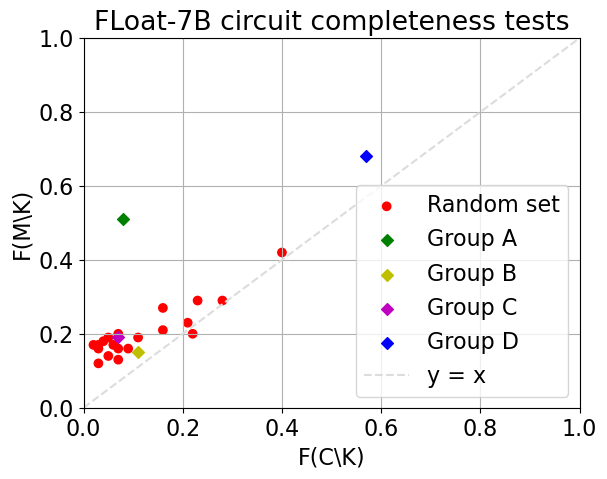

In [16]:
Random_C = C_acc_random
Random_M = M_acc_random
groups_C = C_acc_groups
group_M = M_acc_groups

plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams["font.size"] = 16
fig, ax = plt.subplots()

ax.scatter(Random_C, Random_M, c=len(Random_C) * ["r"], label="Random set")
ax.scatter(groups_C[0], group_M[0], c=["g"], label="Group A", marker="D")
ax.scatter(groups_C[1], group_M[1], c=["y"], label="Group B", marker="D")
ax.scatter(groups_C[2], group_M[2], c=["m"], label="Group C", marker="D")
ax.scatter(groups_C[3], group_M[3], c=["b"], label="Group D", marker="D")


ax.set_ylim(0, 1)
ax.set_xlim(0, 1)
ax.axline((0, 0), slope=1, color="gainsboro", ls="--", label="y = x")

ax.set_ylabel("F(M\K)")
ax.set_xlabel("F(C\K)")
ax.set_title("FLoat-7B circuit completeness tests")
plt.grid()
plt.legend(loc="lower right")

# plt.show()
plt.savefig("./results/figures/float_cir_completeness.pdf", dpi=300)